In [99]:
#Note: change interpreter of jupyter notebook to the .venv(Python 3.10.4) where these libs are installed
# https://stackoverflow.com/questions/67946868/how-do-i-install-pandas-into-visual-studios-code
import pandas as pd 
import numpy as np
import quandl
import math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
##plotting
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
##saving
import pickle

https://pythonprogramming.net/features-labels-machine-learning-tutorial/?completed=/regression-introduction-machine-learning-tutorial/

In [10]:
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
print(df.head())

            Adj. Open  Adj. High   Adj. Low  Adj. Close  Adj. Volume
Date                                                                
2004-08-19  50.159839  52.191109  48.128568   50.322842   44659000.0
2004-08-20  50.661387  54.708881  50.405597   54.322689   22834300.0
2004-08-23  55.551482  56.915693  54.693835   54.869377   18256100.0
2004-08-24  55.792225  55.972783  51.945350   52.597363   15247300.0
2004-08-25  52.542193  54.167209  52.100830   53.164113    9188600.0


In [11]:
#New Features
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
#Rename vars
df.columns = ['adj_close', 'hl_pct', 'pct_change', 'adj_volume']
df.head()

,adj_close,hl_pct,pct_change,adj_volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0


Use numpy to convert data to np arrays, which is what scikit-learn needs.  


In [12]:
## Add new rows for forecasting
forecast_col = 'adj_close'
df.fillna(value=-99999, inplace=True) ##we fill NAs with -99,999 as it will be recognized as an outlier and ignored
forecast_out = int(math.ceil(0.01 * len(df)))

## We're forecasting out 1% of the length of the dataset (about 35 days) 
## Our 'label' feature is the outcome, or what we want to predict. Since we're "forecasting",
## we shift the adjusted close price ('adj_close') down by the forecasting period
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True) ##drop the last 35 rows which are missing labels, since there is no future data to use as a label
df

,adj_close,hl_pct,pct_change,adj_volume,label
Date,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,69.078238
2004-08-20,54.322689,7.921706,7.227007,22834300.0,67.839414
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,3.886792,1.183658,9188600.0,71.219849
...,...,...,...,...,...
2018-01-30,1177.370000,1.139829,-0.029718,1792602.0,1094.000000
2018-01-31,1182.220000,1.202822,-0.134312,1643877.0,1053.150000
2018-02-01,1181.590000,1.530988,0.476195,2774967.0,1026.550000


In [19]:
## Prep data for lin reg
X = np.array(df.drop(labels='label', axis=1))
y = np.array(df['label'])
## Preprocessing
X = preprocessing.scale(X) ##scale the features (note: this won't affect the ability of a linear regression model, just the interpretation of coefficients

In [20]:
## Training & Testing Split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train

array([[-0.80047226, -0.75721983,  0.2891688 ,  1.27332179],
       [-1.02267819,  0.48091901,  0.56191781, -0.33253744],
       [ 0.59364766, -0.06479913,  0.33210779, -0.74924038],
       ...,
       [ 1.95219942, -0.47178249,  0.51300481, -0.70804206],
       [-0.74760056, -0.2618101 ,  0.30836544,  1.4841255 ],
       [-0.63542166,  1.1037321 , -1.79702492, -0.07469498]])

## Training Models

In [22]:
# Model 1: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg_score = linreg.score(X_test, y_test) ##by default, this is R^2
print(linreg_score)

0.9779699277882706


In [24]:
## Inspect the coefficients of the model
pd.DataFrame(zip(df.columns, linreg.coef_))

,0,1
0,adj_close,252.046747
1,hl_pct,-1.934334
2,pct_change,0.051801
3,adj_volume,-2.226250


In [25]:
# Model 2: Support Vector Regression
svreg = svm.SVR()  ##defaults to radial basis function kernel
svreg.fit(X_train, y_train)
svreg_score = svreg.score(X_test, y_test)
print(svreg_score)

0.7872021540796234


In [31]:
## let's try other Kernels for the SVM method
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svk = svm.SVR(kernel=kernel)
    svk.fit(X_train, y_train)
    conf = svk.score(X_test, y_test)
    print(kernel,":", conf)

linear : 0.9767984935108581
poly : 0.6724253083603395
rbf : 0.7872021540796234
sigmoid : 0.8871886509589014


In [33]:
## Coefficients of linear kernel?
svk = svm.SVR(kernel="linear")
svk.fit(X_train, y_train)
pd.DataFrame(svk.coef_) ##slightly different, similair results

,0,1,2,3
0,241.797267,-0.55624,-0.058243,-5.399677


## Prediction
Now that we've seen the LinearRegression is the best peforming model, we can train on the data and forecast out into the forecasting period.

In [58]:
X = np.array(df.drop(labels='label', axis=1))
X = preprocessing.scale(X)
X_future = X[-forecast_out:] ##only the forecast period (35 samples)
X = X[:-forecast_out] ##all rows prior to forecast period

df.dropna(inplace=True)

y = np.array(df['label'])
y = y[:-forecast_out]

## Retrain on full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)
confidence = reg.score(X_test, y_test)
print("confidence:", confidence)


## Make forecast
forecast_values = reg.predict(X_future)
print(forecast_values)

confidence: 0.9771804843500337
[1080.04403798 1094.27561204 1107.79270975 1102.8431573  1096.47820795
 1094.36725275 1093.06873896 1089.12415984 1083.38587605 1078.85550504
 1077.12726361 1094.81413932 1113.4635396  1119.48538835 1133.97948381
 1138.36846287 1136.68808553 1134.31030049 1136.09823268 1153.11524933
 1153.16123711 1162.71256264 1159.46127567 1167.78482587 1187.06384193
 1200.87702537 1194.73837171 1206.76819773 1211.33161166 1211.0320561
 1201.79489989 1206.64477438 1205.3066811  1140.88753697 1084.52480407]


## Visualize Forecast

In [74]:
style.use('ggplot')
df['forecast'] = np.nan ##create empty forecast column on df

#grab the last day in the dataframe, and begin assigning each new forecast to a new day
last_date = df.iloc[-1].name  ##last date in df
last_unix = last_date.timestamp() ##get its timestamp in unix
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_values:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400 ##bump up next unix to the next day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] ##for the new date, imputes missing for all columns but provides forecast for last col

df


,adj_close,hl_pct,pct_change,adj_volume,label,forecast
Date,,,,,,
2004-08-19 00:00:00,50.322842,8.072956,0.324968,44659000.0,69.078238,NaN
2004-08-20 00:00:00,54.322689,7.921706,7.227007,22834300.0,67.839414,NaN
2004-08-23 00:00:00,54.869377,4.049360,-1.227880,18256100.0,68.912727,NaN
2004-08-24 00:00:00,52.597363,7.657099,-5.726357,15247300.0,70.668146,NaN
2004-08-25 00:00:00,53.164113,3.886792,1.183658,9188600.0,71.219849,NaN
...,...,...,...,...,...,...
2018-06-19 20:00:00,NaN,NaN,NaN,NaN,NaN,1201.794900
2018-06-20 20:00:00,NaN,NaN,NaN,NaN,NaN,1206.644774
2018-06-21 20:00:00,NaN,NaN,NaN,NaN,NaN,1205.306681


In [92]:
df.iloc[2000:]

,adj_close,hl_pct,pct_change,adj_volume,label,forecast
Date,,,,,,
2012-07-27 00:00:00,318.463065,2.756079,2.596584,7092300.0,356.089213,NaN
2012-07-30 00:00:00,317.128947,2.071801,-0.589576,4369000.0,360.252064,NaN
2012-07-31 00:00:00,317.464984,1.308119,0.749690,3727400.0,364.876338,NaN
2012-08-01 00:00:00,317.319535,1.284757,-0.724933,3685500.0,365.185593,NaN
2012-08-02 00:00:00,315.348450,2.325249,0.517977,3951400.0,368.131386,NaN
...,...,...,...,...,...,...
2018-06-19 20:00:00,NaN,NaN,NaN,NaN,NaN,1201.794900
2018-06-20 20:00:00,NaN,NaN,NaN,NaN,NaN,1206.644774
2018-06-21 20:00:00,NaN,NaN,NaN,NaN,NaN,1205.306681


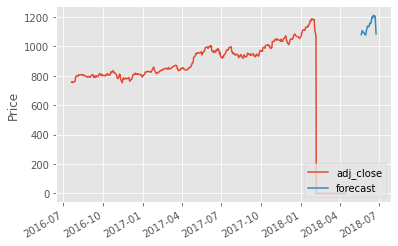

In [98]:
df.iloc[3000:].adj_close.plot()
df['forecast'].plot()
plt.legend(loc=4)
plt.xlabel('')
plt.ylabel('Price')
plt.show()

## Saving the Algorithm
What if we wanted to save this algorithm to predict future stock prices?
With pickle, we can save a python object. 

In [101]:
## Creates a new file and saves the object to it
with open('linregexample.pickle', 'wb') as f:
    pickle.dump(reg, f)

## Opens the pickle object
pickle_in = open('linregexample.pickle', 'rb')
trained_mod = pickle.load(pickle_in)

## Sanity check
new_forecast = trained_mod.predict(X_future)
new_forecast

array([1080.04403798, 1094.27561204, 1107.79270975, 1102.8431573 ,
       1096.47820795, 1094.36725275, 1093.06873896, 1089.12415984,
       1083.38587605, 1078.85550504, 1077.12726361, 1094.81413932,
       1113.4635396 , 1119.48538835, 1133.97948381, 1138.36846287,
       1136.68808553, 1134.31030049, 1136.09823268, 1153.11524933,
       1153.16123711, 1162.71256264, 1159.46127567, 1167.78482587,
       1187.06384193, 1200.87702537, 1194.73837171, 1206.76819773,
       1211.33161166, 1211.0320561 , 1201.79489989, 1206.64477438,
       1205.3066811 , 1140.88753697, 1084.52480407])